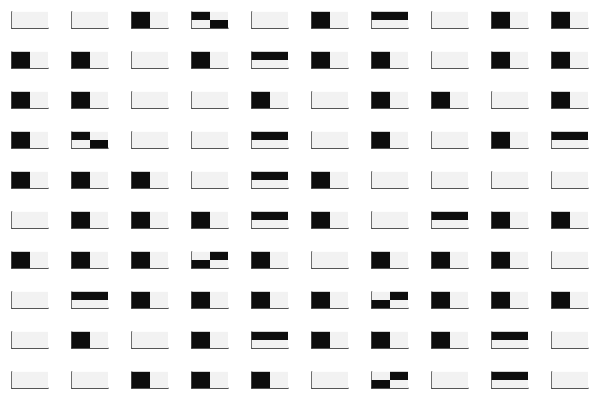

In [ ]:
using Plots
using Yao, FLOYao
using LinearAlgebra
using JLD2
using BitBasis 

n = 2
nq = n^2

function create_circuit(nq::Int)
    layers = 20 #Number of brick-wall layers in the circuit
    g = chain(nq)
    for _ in 1:layers
        for i in 1:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Nearest-neighbor XX rotation gates
        end
        for i in 2:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => Y), 0.)) #Nearest-neighbor XY rotation gates
        end
        for i in 1:nq
            push!(g, put(nq, i => Rz(0.))) #Single qubit Z rotation gates
        end
    end
    return g
end

g = create_circuit(nq)
p = JLD2.load("gparams.jld2")
p = p["gparams"]
dispatch!(g, p)

function d_postprocess(measurement::Vector)
    l = length(measurement)
    aa = breflect.(measurement)
    ret = Matrix(undef, nq, l)
    for i in 1:l
        ret[:,i] = [aa[i]...]
    end
    return ret
end

#Testing the Generator
function sample(reg, theta, nbatch)
    nq = nqubits(reg)
    g = create_circuit(nq)
    dispatch!(g, theta)
    measurements = measure(apply(reg, g), nshots = nbatch)
    return d_postprocess(measurements)
end

nsamples = 100
samples = sample(FLOYao.zero_state(nq), parameters(g), nsamples)
plot([heatmap(reshape(samples[:,i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

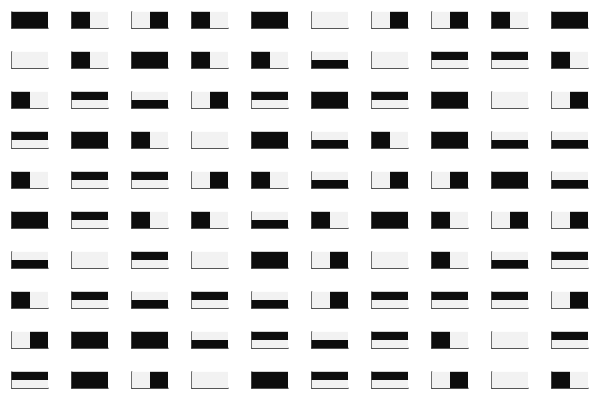

In [ ]:
using Random
using Plots

train = 100 #Number of training data samples

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2?

function bars_and_stripes(train = 10, repeats = true) #Samples 'train' data samples from the nxn bars_and_stripes synthetic dataset uniformly and with replacement if 'repeats' = true
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n #If it's all black or all white
            ret = flip ? b : .!b
        else #If not monochromatic, then it's vertical/horizontal with 1/2 probability
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

display = bars_and_stripes(train) #Stores data in data_train
data_train = display .|> vec
data_train[1] = Int.(data_train[1])

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in display]...)